In [ ]:
# Import Libraries

import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns

import xgboost as xgb
from tqdm import tqdm
from pathlib import Path
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [16]:
# Create Folder Structure

processed_base = "C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Machine Learning/Project/Project/Project Code & Data/Data/processed"
labels = ["recycling", "compost", "general"]

# Create folders for train/val/test under each label
for split in ["train", "val", "test"]:
    for label in labels:
        Path(f"{processed_base}/{split}/{label}").mkdir(parents=True, exist_ok=True)

print("Folder structure for processed data created.")

Folder structure for processed data created.


To prepare the dataset for training and testing, this block of code creates a folder structure. It sets up separate folders for training, validation and testing under each waste category of recycling, compost and general. These folders will later be used to store the corresponding images making it easier for the model to read and learn from them. The structure also follows the format expected by image classification tools like Keras' "flow_from_directory".

DEEP LEARNING MODEL

In [17]:
# Load and Preprocess Images

# Resize images to fit MobileNetV2
IMAGE_SIZE = (224, 224)

def load_all_images_from_subfolders(base_path):
    images = []
    for subdir, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                images.append(Path(subdir) / file)
    return images

def preprocess_and_split_images(src_folder, label, dst_base, split_ratio=(0.7, 0.15, 0.15)):
    images = load_all_images_from_subfolders(src_folder)
    print(f"Found {len(images)} images in {label}")
    if len(images) < 10:
        print(f"Not enough images to split for {label}. Skipping.")
        return
    random.shuffle(images)
    train, test = train_test_split(images, test_size=1 - split_ratio[0], random_state=42)
    val, test = train_test_split(test, test_size=split_ratio[2] / (split_ratio[1] + split_ratio[2]), random_state=42)
    dataset = {'train': train, 'val': val, 'test': test}
    for split, files in dataset.items():
        for img_path in tqdm(files, desc=f"{label.upper()} - {split.upper()}"):
            try:
                img = cv2.imread(str(img_path))
                img = cv2.resize(img, IMAGE_SIZE)
                img = img / 255.0
                save_path = f"{dst_base}/{split}/{label}/{img_path.name}"
                cv2.imwrite(save_path, (img * 255).astype('uint8'))
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")


This code is responsible for loading all images from the given folders and preparing them for training. First, it searches through all subfolders within each category like recycling, compost and general and collects the image files. It then splits these images into three groups of training (70%), validation (15%) and testing (15%) which helps evaluate the model fairly during and after training. Each image is resized to 224 by 224 pixels which is the input size required by the MobileNetV2 model. The images are also normalized by scaling pixel values between 0 and 1 making it easier for the model to learn. Finally, the processed images are saved into their respective folders based on the split by keeping the dataset clean and organized for the next steps.

In [ ]:
# Apply preprocessing to Household Dataset
household_path = "C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Machine Learning/Project/Project/Project Code & Data/Data/household"

preprocess_and_split_images(f"{household_path}/recycling", "recycling", processed_base)
preprocess_and_split_images(f"{household_path}/compost", "compost", processed_base)
preprocess_and_split_images(f"{household_path}/general", "general", processed_base)

Found 6500 images in recycling


RECYCLING - TEST: 100%|██████████| 976/976 [00:07<00:00, 124.55it/s]


Found 2000 images in compost


COMPOST - TEST: 100%|██████████| 301/301 [00:02<00:00, 107.39it/s]


Found 6500 images in general


GENERAL - TEST: 100%|██████████| 976/976 [00:08<00:00, 116.97it/s]


This section applies the previously defined image preprocessing function to the actual household waste dataset. It goes through the folders for each category—recycling, compost and general and runs the preprocessing logic on all images within them. That means it loads, resizes, normalizes and splits each image into the appropriate training, validation or testing folder structure. This step ensures that the real-world dataset is clean, standardized and ready to be used by the machine learning models.

In [8]:
# Apply preprocessing to Garbage Dataset
garbage_path = "C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Machine Learning/Project/Project/Project Code & Data/Data/garbage_dataset"

preprocess_and_split_images(f"{garbage_path}/recycling", "recycling", processed_base)
preprocess_and_split_images(f"{garbage_path}/general", "general", processed_base)
preprocess_and_split_images(f"{garbage_path}/compost", "compost", processed_base)

Found 9570 images in recycling


RECYCLING - TEST: 100%|██████████| 1436/1436 [00:10<00:00, 138.76it/s]


Found 9195 images in general


GENERAL - TEST: 100%|██████████| 1380/1380 [00:07<00:00, 192.61it/s]


Found 997 images in compost


COMPOST - TEST: 100%|██████████| 150/150 [00:00<00:00, 195.99it/s]


This part of the code applies the same preprocessing routine to garbage dataset. Just like with the household dataset, it processes the recycling, general and compost image folders by resizing, normalizing and splitting the images into training, validation and testing sets. By combining and preparing data from both household and garbage sources, the model benefits from a more diverse and representative training set by improving its ability to generalize to new types of waste images.

In [9]:
# Apply preprocessing to waste_classification Dataset
waste_classification_path = "C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Machine Learning/Project/Project/Project Code & Data/Data/waste_classification"

preprocess_and_split_images(f"{waste_classification_path}/compost", "compost", processed_base)
preprocess_and_split_images(f"{waste_classification_path}/recycling", "recycling", processed_base)

Found 13966 images in compost


COMPOST - TEST: 100%|██████████| 2095/2095 [00:09<00:00, 225.06it/s]


Found 11111 images in recycling


RECYCLING - TEST: 100%|██████████| 1667/1667 [00:07<00:00, 216.13it/s]


This section handles preprocessing for waste_classification dataset. It specifically processes the compost and recycling categories  and not generalas it is not available in this dataset. It follows the same procedure of resizing the images to 224x224, normalizing them and splitting them into training, validation and testing sets. Adding this dataset increases the volume and variety of training data helping the model learn from different image sources and environments.

PRE-PROCESSING AND IMAGE DATA GENERATORS

In [ ]:
# Set image input size and batch size
img_height = 224
img_width = 224
batch_size = 32

# Augment training images to improve model generalization
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# Rescale validation and test images (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load training, validation and test images
train_generator = train_datagen.flow_from_directory(directory=f"{processed_base}/train", target_size=(img_height, img_width), 
            batch_size=batch_size, class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory(directory=f"{processed_base}/val", target_size=(img_height, img_width), 
            batch_size=batch_size, class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(directory=f"{processed_base}/test", target_size=(img_height, img_width), 
            batch_size=batch_size, class_mode='categorical', shuffle=False)

print("Class Labels:", train_generator.class_indices)

Found 41326 images belonging to 3 classes.
Found 14101 images belonging to 3 classes.
Found 14112 images belonging to 3 classes.
Class Labels: {'compost': 0, 'general': 1, 'recycling': 2}


This section sets the image input size and batch size required for training. It then defines how images should be processed before feeding them into the model. For the training images various augmentation techniques like rotation, zoom, shifting and flipping are applied to improve the model’s ability to generalize and avoid overfitting. Validation and test images are only rescaled since augmentation isn't applied during evaluation. After that, images are loaded from their respective folders—train, val and test with all images resized to 224x224 pixels. Finally, the labels - recycling, compost and general assigned to the classes are printed to confirm correct mapping.

CNN

In [ ]:
# Load MobileNetV2 model without top layers (pre-trained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add new layers on top for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(3, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set early stopping and model checkpoint to save best model
callbacks = [EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'), ModelCheckpoint('best_model.h5', save_best_only=True)]

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=callbacks)

c:\Users\moham\anaconda3\envs\nci12\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8495 - loss: 0.4059

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 843s 650ms/step - accuracy: 0.8495 - loss: 0.4058 - val_accuracy: 0.9157 - val_loss: 0.2407
Epoch 2/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9093 - loss: 0.2519

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 761s 589ms/step - accuracy: 0.9093 - loss: 0.2519 - val_accuracy: 0.9233 - val_loss: 0.2268
Epoch 3/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9195 - loss: 0.2256

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 766s 593ms/step - accuracy: 0.9195 - loss: 0.2256 - val_accuracy: 0.9289 - val_loss: 0.2140
Epoch 4/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9233 - loss: 0.2190

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 762s 590ms/step - accuracy: 0.9233 - loss: 0.2190 - val_accuracy: 0.9270 - val_loss: 0.2131
Epoch 5/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.9282 - loss: 0.1999

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 771s 597ms/step - accuracy: 0.9282 - loss: 0.1999 - val_accuracy: 0.9343 - val_loss: 0.1941
Epoch 6/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9295 - loss: 0.1952

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 752s 582ms/step - accuracy: 0.9295 - loss: 0.1952 - val_accuracy: 0.9367 - val_loss: 0.1895
Epoch 7/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 1012s 783ms/step - accuracy: 0.9328 - loss: 0.1889 - val_accuracy: 0.9367 - val_loss: 0.1903
Epoch 8/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.9353 - loss: 0.1788

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 1022s 791ms/step - accuracy: 0.9353 - loss: 0.1788 - val_accuracy: 0.9446 - val_loss: 0.1644
Epoch 9/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.9378 - loss: 0.1776

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 1338s 1s/step - accuracy: 0.9378 - loss: 0.1776 - val_accuracy: 0.9449 - val_loss: 0.1635
Epoch 10/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9409 - loss: 0.1666

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 1043s 807ms/step - accuracy: 0.9409 - loss: 0.1666 - val_accuracy: 0.9437 - val_loss: 0.1616
Epoch 11/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 1295s 957ms/step - accuracy: 0.9374 - loss: 0.1713 - val_accuracy: 0.9440 - val_loss: 0.1631
Epoch 12/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9433 - loss: 0.1607

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 871s 674ms/step - accuracy: 0.9433 - loss: 0.1607 - val_accuracy: 0.9466 - val_loss: 0.1563
Epoch 13/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9426 - loss: 0.1568

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 778s 602ms/step - accuracy: 0.9426 - loss: 0.1568 - val_accuracy: 0.9492 - val_loss: 0.1520
Epoch 14/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 718s 556ms/step - accuracy: 0.9446 - loss: 0.1536 - val_accuracy: 0.9479 - val_loss: 0.1551
Epoch 15/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9439 - loss: 0.1493

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 717s 555ms/step - accuracy: 0.9439 - loss: 0.1493 - val_accuracy: 0.9495 - val_loss: 0.1513
Epoch 16/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9476 - loss: 0.1473

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 717s 555ms/step - accuracy: 0.9476 - loss: 0.1473 - val_accuracy: 0.9499 - val_loss: 0.1489
Epoch 17/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 757s 586ms/step - accuracy: 0.9456 - loss: 0.1532 - val_accuracy: 0.9508 - val_loss: 0.1490
Epoch 18/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9482 - loss: 0.1408

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 715s 553ms/step - accuracy: 0.9482 - loss: 0.1408 - val_accuracy: 0.9518 - val_loss: 0.1466
Epoch 19/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 720s 557ms/step - accuracy: 0.9496 - loss: 0.1422 - val_accuracy: 0.9497 - val_loss: 0.1518
Epoch 20/20
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9494 - loss: 0.1410

1292/1292 ━━━━━━━━━━━━━━━━━━━━ 714s 552ms/step - accuracy: 0.9494 - loss: 0.1410 - val_accuracy: 0.9520 - val_loss: 0.1381


This section defines and trains the core deep learning model for the waste classification task. A pre-trained MobileNetV2 model is loaded without its top layers allowing it to serve as a feature extractor. Its weights are frozen to retain learned knowledge from the ImageNet dataset. New layers are added on top to adapt it for classifying waste into three categories of compost, recycling and general. These layers include global average pooling, dropout layers to reduce overfitting and a final dense layer with softmax activation for multiclass classification. The model is compiled using the Adam optimizer and categorical crossentropy as the loss function. Early stopping is used to halt training if validation performance stops improving and the best version of the model is saved. Finally, the model is trained on the training set with validation performance monitored across 20 epochs.

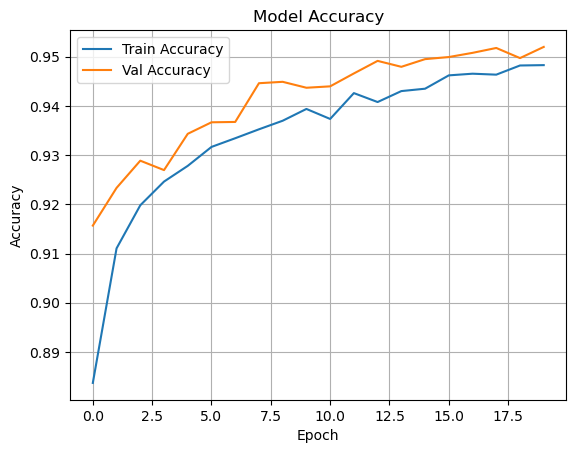

In [34]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

The plot shows the training and validation accuracy for each epoch as the model learns. The blue line represents how well the model performs on the training data while the orange line shows its performance on unseen validation data. The upward trend in both lines indicates that the model is learning effectively and generalizing well. A minimal gap between the two curves also suggests that the model is not overfitting and the early stopping callback helped prevent unnecessary training beyond the optimal point. This visualization helps confirm that the training process was successful.

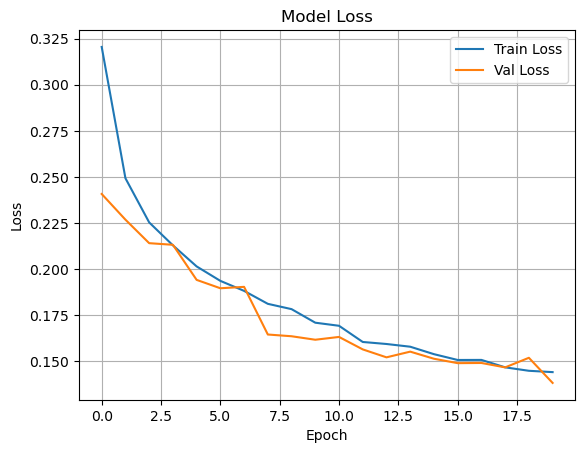

In [35]:
# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

The plot displays both training and validation loss across all epochs. The loss value indicates how far off the model's predictions are from the actual values as lower is better. The blue line represents the training loss and the orange line shows the validation loss. Both lines steadily decline which means the model is successfully minimizing errors. The fact that the validation loss closely follows the training loss suggests that the model is not overfitting and is performing well on unseen data too.

In [36]:
# Save the model
model.save("final_waste_classifier_model.keras")

In [ ]:
# Load the trained model
model = load_model("final_waste_classifier_model.keras")

In [38]:
# Evaluate on test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

441/441 ━━━━━━━━━━━━━━━━━━━━ 152s 339ms/step - accuracy: 0.9451 - loss: 0.1561
Test Accuracy: 0.9517
Test Loss: 0.1436


The trained waste classification model was saved using the .keras format to ensure it can be reloaded later without needing to retrain. After saving, the model was reloaded and evaluated on the test dataset which was kept separate from training and validation. This evaluation helps check how well the model performs on completely unseen data. The results show that the model achieved a test accuracy of 95.17% indicating strong performance and a test loss of 0.1436 suggesting low prediction error.

In [ ]:
# Generate Confusion Matrix and Classification Report

# Predict classes on test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

441/441 ━━━━━━━━━━━━━━━━━━━━ 151s 336ms/step
Classification Report:
              precision    recall  f1-score   support

     compost       0.97      0.97      0.97      5781
     general       0.96      0.83      0.89      1687
   recycling       0.94      0.97      0.95      6644

    accuracy                           0.95     14112
   macro avg       0.95      0.92      0.94     14112
weighted avg       0.95      0.95      0.95     14112



After evaluating the model, predictions were made on the test dataset to further analyze performance. The predicted class labels were compared with the actual labels using two tools:
1. Classification Report: This report provides precision, recall and F1-score for each waste category of compost, general and recycling. The model performed best on compost and recycling with high precision and recall. The general category had slightly lower recall indicating it was sometimes misclassified.
2. Confusion Matrix: The confusion matrix was computed to show how many instances from each class were correctly or incorrectly predicted. This helps in understanding where the model is making errors.
The overall accuracy remained strong at 95% confirming that the model is performing consistently across different metrics.

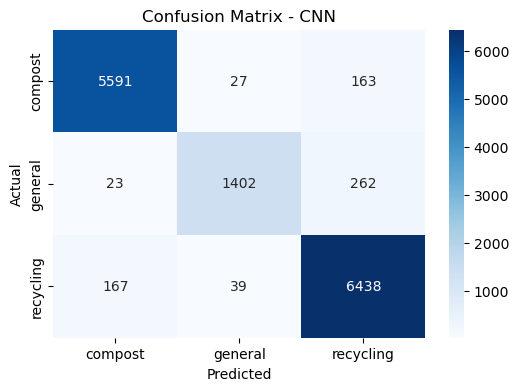

In [ ]:
# Plot the confusion matrix using heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN')
plt.show()

This heatmap visually represents the confusion matrix for the CNN model. Each row corresponds to the actual class and each column corresponds to the predicted class. The diagonal values from top-left to bottom-right show the number of correctly classified images for each waste type:
1. Compost: 5,591 images correctly identified with 190 misclassified.
2. General: 1,402 images correctly predicted but 262 were incorrectly marked as recycling.
3. Recycling: 6,438 images correctly predicted though 206 were confused with other categories.
Darker shades indicate higher values making it easier to spot strengths and areas where the model struggles. While the model performs well overall, a few misclassifications still occur between visually similar items like general and recycling.

In [ ]:
# Get the file paths, identify which predictions were correct and which were incorrect
file_paths = test_generator.filepaths
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

This cell helps in evaluating how well the trained model performed on the test data by identifying which images were predicted correctly and which were not. It starts by extracting the file paths of all test images using the test_generator.filepaths. Then it compares the predicted class labels (y_pred_classes) with the actual class labels (y_true). If the predicted label matches the actual label the index of that image is added to the correct_indices list. If the prediction does not match the actual label, the index is stored in the incorrect_indices list. These lists are helpful for further analysis and visualization of model performance especially for understanding where the model is making mistakes.

In [ ]:
# Define a function to visually show sample predictions (either correct or incorrect)
def show_predictions(indices, title, n=5):
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(random.sample(list(indices), n)):
        img_path = file_paths[idx]
        true_label = class_labels[y_true[idx]]
        pred_label = class_labels[y_pred_classes[idx]]
        img = load_img(img_path, target_size=(224, 224))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

This cell defines a custom function called show_predictions() which is used to visually display a sample of predictions made by the model. It helps in analyzing how the model is performing by showing either correct or incorrect predictions. The function accepts three parameters: indices which are either correct or incorrect prediction indices, a title to be displayed above the plots and n - the number of images to show (default is 5). It randomly selects n images from the given indices and loads each image. For each image, it displays the actual label and the predicted label and uses green color for correct predictions and red for incorrect ones. This visualization provides an intuitive understanding of how the model is classifying different types of waste.

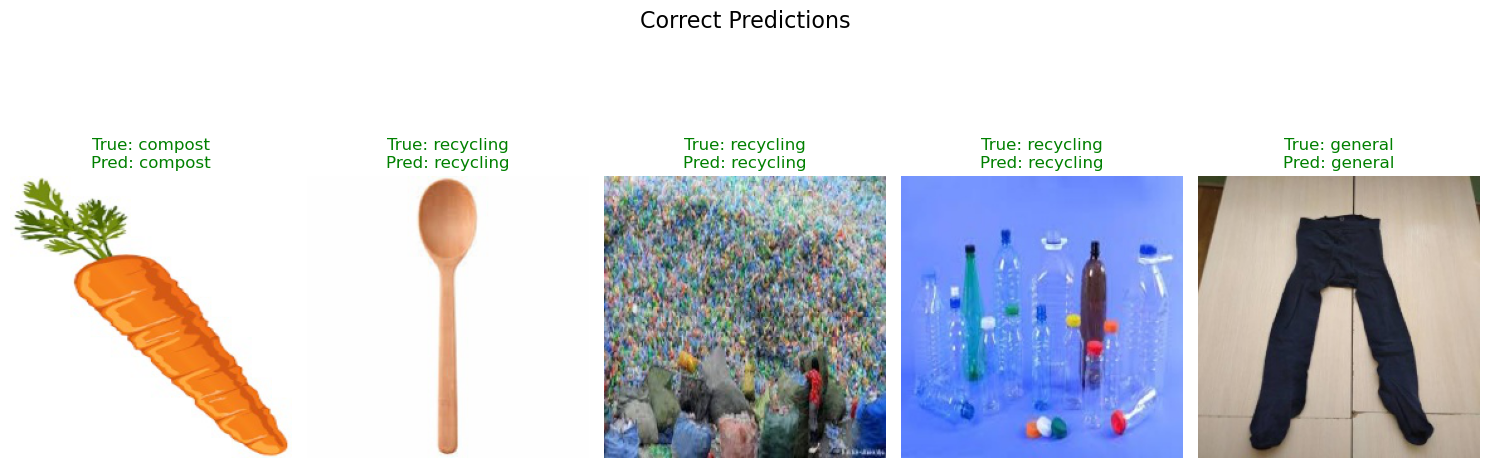

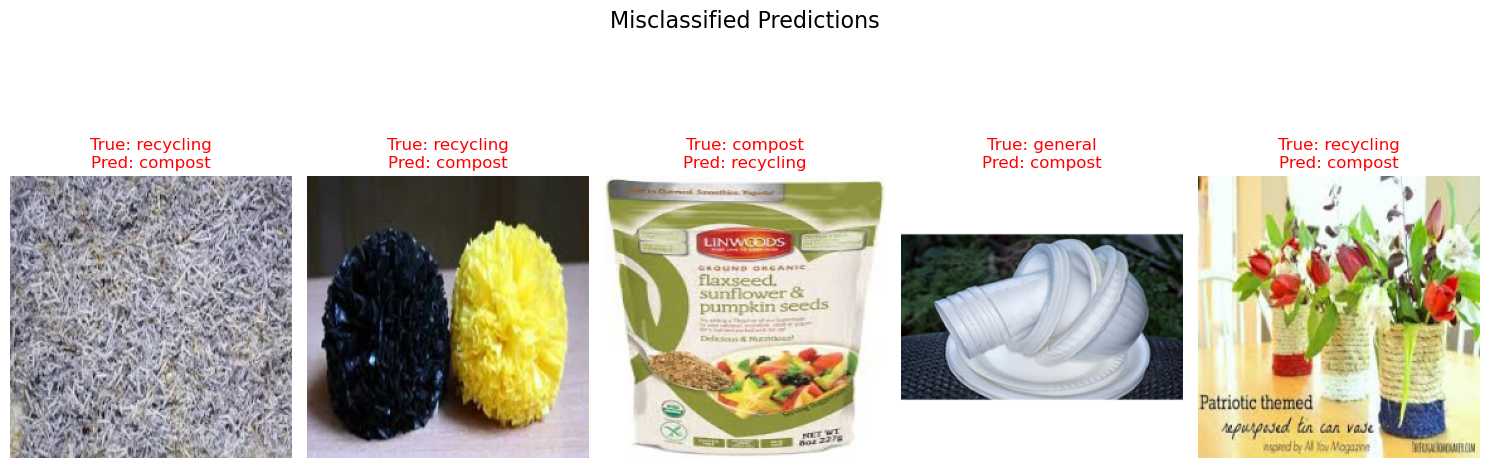

In [ ]:
# Display 5 examples where the model predicted correctly
show_predictions(correct_indices, title="Correct Predictions", n=5)

# Display 5 examples where the model made wrong predictions
show_predictions(incorrect_indices, title="Misclassified Predictions", n=5)

These plots showcase sample predictions made by the trained model. The first figure titled "Correct Predictions" shows five images where the predicted class matched the true class label. Each image is displayed along with the actual and predicted labels in green text indicating the model's accurate performance.

The second figure titled "Misclassified Predictions" presents five images where the model made incorrect predictions. Here, the true and predicted labels are shown in red, highlighting the areas where the model struggled. This visualization is useful in identifying patterns in the model’s mistakes and exploring potential improvements for future versions such as refining the dataset or applying additional data augmentation techniques.

TRADITIONAL MACHINE LEARNING

In [18]:
# Load MobileNetV2 pre-trained model for feature extraction (without top classification layer)
mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# Apply MobileNetV2-specific preprocessing to images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load training, validation and test datasets for ML-based models
train_generator_ml = datagen.flow_from_directory(directory=f"{processed_base}/train", target_size=(224, 224), batch_size=32,
    class_mode='sparse', shuffle=False)

val_generator_ml = datagen.flow_from_directory(directory=f"{processed_base}/val", target_size=(224, 224), batch_size=32,
    class_mode='sparse', shuffle=False)

test_generator_ml = datagen.flow_from_directory(directory=f"{processed_base}/test", target_size=(224, 224), batch_size=32,
    class_mode='sparse', shuffle=False)

# Use MobileNet to extract features from images
train_features = mobilenet.predict(train_generator_ml, verbose=1)
val_features = mobilenet.predict(val_generator_ml, verbose=1)
test_features = mobilenet.predict(test_generator_ml, verbose=1)

# Save extracted features and true labels for ML model training
np.save('features_train_mobilenet.npy', train_features)
np.save('features_val_mobilenet.npy', val_features)
np.save('features_test_mobilenet.npy', test_features)

np.save('labels_train_mobilenet.npy', train_generator_ml.classes)
np.save('labels_val_mobilenet.npy', val_generator_ml.classes)
np.save('labels_test_mobilenet.npy', test_generator_ml.classes)

Found 41326 images belonging to 3 classes.
Found 14101 images belonging to 3 classes.
Found 14112 images belonging to 3 classes.


c:\Users\moham\anaconda3\envs\nci12\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1292/1292 ━━━━━━━━━━━━━━━━━━━━ 548s 420ms/step
441/441 ━━━━━━━━━━━━━━━━━━━━ 163s 370ms/step
441/441 ━━━━━━━━━━━━━━━━━━━━ 161s 365ms/step


This part of the code prepares feature data for traditional machine learning models using MobileNetV2 as a feature extractor. The MobileNetV2 model is loaded without its final classification layers allowing it to output high-level features from images instead of predictions. A specific preprocessing function defined for MobileNetV2 is applied to the image data using ImageDataGenerator.

Next, the training, validation and test images are loaded without shuffling ensuring label order is preserved. These images are passed through the MobileNetV2 model to extract feature vectors which act as compact numerical representations of the images.

Finally, these extracted features and their corresponding class labels are saved as .npy files. These saved arrays will later be used to train traditional machine learning classifiers like SVM, KNN and XGBoost. This step effectively bridges deep learning and classical machine learning approaches in the project.

SVM

In [23]:
# Load the previously saved features and labels
data_path = "C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Machine Learning/Project/Project/Project Code & Data"

X_train = np.load(f"{data_path}/features_train_mobilenet.npy")
X_val = np.load(f"{data_path}/features_val_mobilenet.npy")
X_test = np.load(f"{data_path}/features_test_mobilenet.npy")

y_train = np.load(f"{data_path}/labels_train_mobilenet.npy")
y_val = np.load(f"{data_path}/labels_val_mobilenet.npy")
y_test = np.load(f"{data_path}/labels_test_mobilenet.npy")

In [24]:
# Combine the training and validation data into one set
X_train_combined = np.concatenate((X_train, X_val), axis=0)
y_train_combined = np.concatenate((y_train, y_val), axis=0)

In [25]:
# Randomly select 5000 samples from the combined data to make SVM training faster
X_sampled, y_sampled = resample(X_train_combined, y_train_combined, n_samples=5000, random_state=42)
X_sampled.shape, y_sampled.shape

((5000, 1280), (5000,))

This section loads the feature vectors and corresponding labels that were previously extracted and saved using MobileNetV2. These files (.npy) represent compressed representations of the images (features) and their true class labels (compost, general or recycling).

After loading the training, validation and test sets, the training and validation sets are combined. This is a common practice when the model needs to be retrained or fine-tuned on a larger dataset before final evaluation. By merging these two datasets, the model will have access to more samples during training which can potentially improve generalization and performance when evaluated on the unseen test data.

In [26]:
# Train SVM model with linear kernel
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_sampled, y_sampled)

SVC(kernel='linear', probability=True)

In [27]:
# Predict on test data
svm_y_pred = svm_model.predict(X_test)

This block of code trains a SVM using the previously extracted MobileNetV2 features. The SVM is configured with a linear kernel which is effective for high-dimensional data like feature vectors. The model is also set to return probability estimates for each class by enabling the probability=True parameter.

Once trained on the sampled dataset (X_sampled, y_sampled), the SVM model is used to make predictions on the test dataset (X_test). This allows evaluating the SVM built on top of deep learning-based feature extraction.

In [28]:
# Evaluation metrics
svm_accuracy_score = accuracy_score(y_test, svm_y_pred)
svm_classification_report = classification_report(y_test, svm_y_pred, target_names=["compost", "general", "recycling"])
svm_confusion_matrix = confusion_matrix(y_test, svm_y_pred)

# Accuracy
print(f"SVM Test Accuracy: {svm_accuracy_score:.4f}")

# Classification report
print("SVM Classification Report:\n")
print(classification_report(y_test, svm_y_pred, target_names=['compost', 'general', 'recycling']))

SVM Test Accuracy: 0.8901
SVM Classification Report:

              precision    recall  f1-score   support

     compost       0.91      0.92      0.92      5781
     general       0.83      0.74      0.78      1687
   recycling       0.88      0.90      0.89      6644

    accuracy                           0.89     14112
   macro avg       0.88      0.86      0.86     14112
weighted avg       0.89      0.89      0.89     14112



This cell evaluates the SVM model's performance on the test data. It calculates the overall accuracy which is 89.01% and prints a classification report showing precision, recall and F1-score for each class—compost, general and recycling. The model performs well overall especially on compost and recycling with slightly lower performance for the general class. The evaluation helps understand how effectively the model distinguishes between different types of waste.

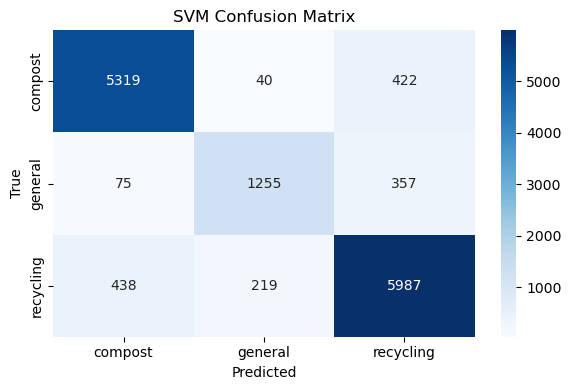

In [29]:
# Plot confusion matrix for SVM model
plt.figure(figsize=(6,4))
sns.heatmap(svm_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["compost", "general", "recycling"], yticklabels=["compost", "general", "recycling"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.tight_layout()
plt.show()

This cell generates a confusion matrix for the SVM model to visually compare the predicted labels against the actual labels for compost, general and recycling waste. Darker shades along the diagonal indicate more correct predictions while off-diagonal values highlight misclassifications. It helps understand where the model performs well and where it struggles such as confusing recycling with compost in some cases.

KNN

In [30]:
# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_combined, y_train_combined)

KNeighborsClassifier()

In [31]:
# Predict on test data
knn_y_pred = knn_model.predict(X_test)

In this step, KNN model is trained using the combined training and validation feature set. The number of neighbors (k=5) determines that the prediction for a given test sample is based on the five nearest training samples. After training, the model is used to predict the class labels for the test data which helps evaluate how well KNN performs on the waste classification task using the extracted MobileNetV2 features.

In [32]:
# Evaluation metrics
knn_accuracy_score = accuracy_score(y_test, knn_y_pred)
knn_classification_report = classification_report(y_test, knn_y_pred, target_names=["compost", "general", "recycling"])
knn_confusion_matrix = confusion_matrix(y_test, knn_y_pred)

# Accuracy
print(f"KNN Test Accuracy: {knn_accuracy_score:.4f}")

# Classification report
print("KNN Classification Report:\n")
print(classification_report(y_test, knn_y_pred, target_names=['compost', 'general', 'recycling']))

KNN Test Accuracy: 0.9482
KNN Classification Report:

              precision    recall  f1-score   support

     compost       0.97      0.95      0.96      5781
     general       0.93      0.85      0.89      1687
   recycling       0.93      0.97      0.95      6644

    accuracy                           0.95     14112
   macro avg       0.95      0.92      0.93     14112
weighted avg       0.95      0.95      0.95     14112



The performance of the KNN model was evaluated using standard classification metrics. The model achieved an accuracy of approximately 94.82% on the test dataset. The classification report indicates strong precision and recall across all three classes: compost, general and recycling. Compost and recycling categories were especially well-classified with F1-scores close to 0.95. Although the general class showed slightly lower recall overall the KNN model demonstrated high reliability and balance in predictions making it a strong traditional ML alternative when used with MobileNetV2 features.

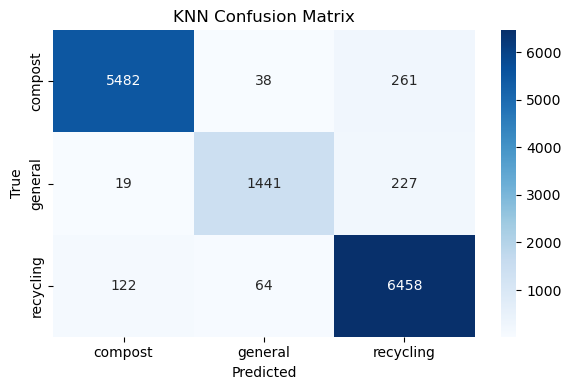

In [33]:
# Plot confusion matrix for KNN model
plt.figure(figsize=(6,4))
sns.heatmap(knn_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["compost", "general", "recycling"], yticklabels=["compost", "general", "recycling"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.tight_layout()
plt.show()

The confusion matrix for the KNN model provides a visual representation of how accurately the model classified each category. Most compost and recycling images were correctly identified with only a few misclassified into other categories. The general category had slightly more confusion particularly with recycling items but overall the matrix confirms that the KNN model performed reliably with minimal errors. The diagonal dominance in the heatmap reflects the model’s strong predictive power.

Gradient Boosting

In [34]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train_combined, y_train_combined)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [35]:
# Predict on test data
xgb_y_pred = xgb_model.predict(X_test)

In this step, the XGBoost model is trained using the features extracted from MobileNetV2. XGBoost is used for structured data and is known for its speed and performance. The model is initialized with the evaluation metric set to mlogloss which is appropriate for multi-class classification tasks. Once trained, the model is used to make predictions on the test dataset allowing us to assess its ability to correctly classify waste images into compost, general or recycling categories.

In [36]:
# Evaluation metrics
xgb_accuracy_score = accuracy_score(y_test, xgb_y_pred)
xgb_classification_report = classification_report(y_test, xgb_y_pred, target_names=["compost", "general", "recycling"])
xgb_confusion_matrix = confusion_matrix(y_test, xgb_y_pred)

# Accuracy
print(f"XGB Test Accuracy: {xgb_accuracy_score:.4f}")

# Classification report
print("XGB Classification Report:\n")
print(classification_report(y_test, xgb_y_pred, target_names=['compost', 'general', 'recycling']))

XGB Test Accuracy: 0.9735
XGB Classification Report:

              precision    recall  f1-score   support

     compost       0.99      0.99      0.99      5781
     general       0.99      0.83      0.90      1687
   recycling       0.95      1.00      0.97      6644

    accuracy                           0.97     14112
   macro avg       0.98      0.94      0.96     14112
weighted avg       0.97      0.97      0.97     14112



The performance of the XGBoost model was evaluated using standard classification metrics. It achieved a high overall test accuracy of 97.35% indicating strong performance across the three waste categories. The classification report showed excellent precision and recall for the compost and recycling classes with precision values close to 0.99 and 0.95 respectively. The general class had slightly lower recall at 0.83 but still maintained a high precision of 0.99. These results demonstrate that the XGBoost model effectively distinguishes between different waste types with especially strong accuracy in identifying compost and recycling items.

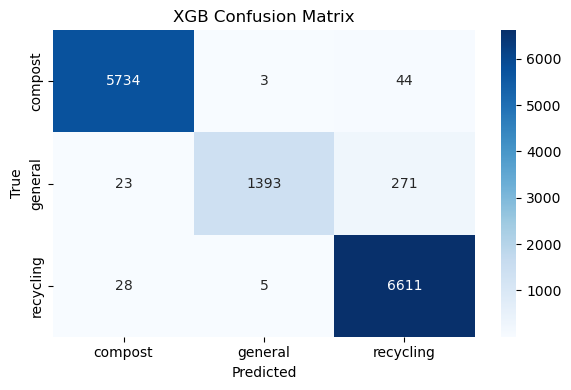

In [37]:
# Plot confusion matrix for XGBoost model
plt.figure(figsize=(6,4))
sns.heatmap(xgb_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["compost", "general", "recycling"], yticklabels=["compost", "general", "recycling"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGB Confusion Matrix')
plt.tight_layout()
plt.show()

The confusion matrix for the XGBoost model provides a clear visualization of its strong performance in classifying waste categories. Most of the compost and recycling samples were correctly identified with only a few misclassifications. The general class had slightly more confusion with the recycling class but overall the matrix confirms that the model performed well with minimal error. The matrix reinforces the high accuracy observed in earlier evaluation metrics and highlights the model's ability to distinguish between different types of waste with great precision.

MODELS COMPARISON

In [ ]:
# Comparison table of all models based on their test accuracy (in %)
model_accuracies = {'CNN (DL)': 95.20, 'SVM (ML)': 89.01, 'KNN (ML)': 94.82, 'XGBoost (ML)': 97.35}

# Convert dictionary to a DataFrame
comparison_df = pd.DataFrame(model_accuracies.items(), columns=['Model', 'Test Accuracy (%)'])

# Display table
styled_df = comparison_df.style.format({'Test Accuracy (%)': '{:.2f}'}).hide(axis='index')
display(styled_df)

Model,Test Accuracy (%)
CNN (DL),95.20
SVM (ML),89.01
KNN (ML),94.82
XGBoost (ML),97.35


The final comparison table summarizes the performance of all the models tested in this project based on their accuracy on the test set. XGBoost emerged as the most accurate model achieving a test accuracy of 97.35% followed by the CNN deep learning model with 95.20% and then KNN at 94.82%. The SVM model had the lowest accuracy at 89.01% but still showed decent performance. This table provides a clear and concise overview of how each model performed helping to identify which techniques are most suitable for waste classification using image data.

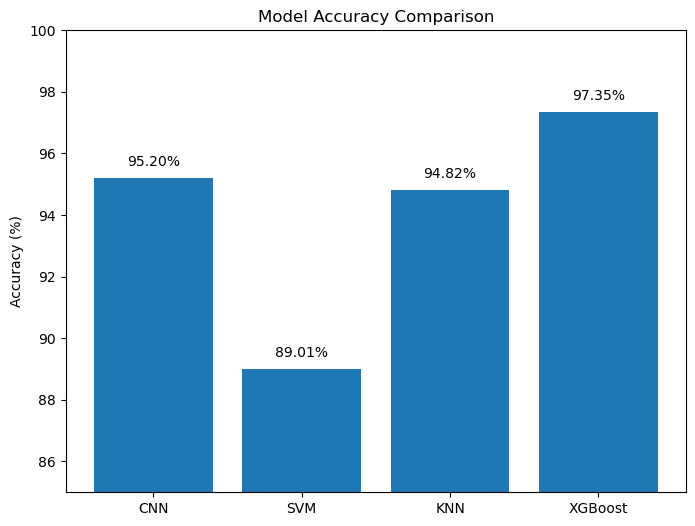

In [ ]:
# Model names and corresponding accuracy values
models = ['CNN', 'SVM', 'KNN', 'XGBoost']
accuracies = [95.20, 89.01, 94.82, 97.35]  # All values in %

# Plot a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.3, f'{yval:.2f}%', ha='center', va='bottom')

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(85, 100)
plt.show()


This bar chart visually compares the test accuracy of all models used in the waste classification project. The XGBoost model stands out with the highest accuracy of 97.35% demonstrating strong predictive capability. CNN also performed well at 95.20% indicating the effectiveness of deep learning with transfer learning. KNN followed closely with 94.82% while SVM had a lower accuracy of 89.01% possibly due to its linear assumptions. This visualization provides a quick and intuitive understanding of which models were most effective for the classification task.

MODEL INFERENCE ON REAL WORLD WASTE IMAGE

Test Random Image 1 - Onion Waste

In [ ]:
# Load trained CNN model
model = load_model("best_model.h5")

# Load and preprocess the image
img_path = "C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Machine Learning/Project/Project/Project Code & Data/Data/test_new_images/onion_waste.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [ ]:
# Predict the class of the uploaded image using the trained CNN model
predictions = model.predict(img_array)
class_index = np.argmax(predictions)

# Map index to label
class_labels = ['compost', 'general', 'recycling']
predicted_label = class_labels[class_index]
confidence = predictions[0][class_index] * 100

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


This final block of code demonstrates how to use the trained CNN model to classify a new image—in this case, a photo of onion waste. The image is first loaded and resized to the expected input dimensions of MobileNetV2 (224x224 pixels). It is then converted into a NumPy array and preprocessed using the same steps as during training to ensure consistency. The model then predicts the category of the image—whether it's compost, general or recycling and outputs the predicted label along with the confidence level. This shows how the model can be practically used for real-world waste classification.

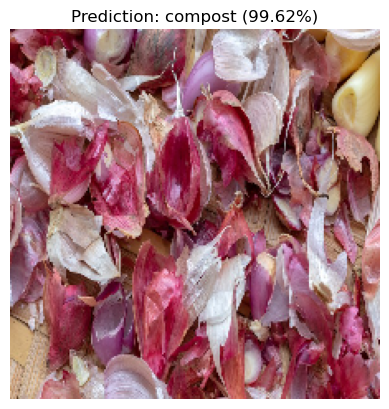

In [48]:
# Show result
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)")
plt.show()

This visualization displays the final prediction result made by the trained CNN model. The image shown is of onion peels which the model successfully identifies as compost with a high confidence of 99.62%. This confirms the model's capability to generalize well and make accurate real-time predictions on new, unseen waste images. The result also illustrates how the system can be used in a real-world application—like sorting waste in smart bins or recycling apps—by simply uploading a photo.

Test Random Image 2 - Empty Milk Bottle

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


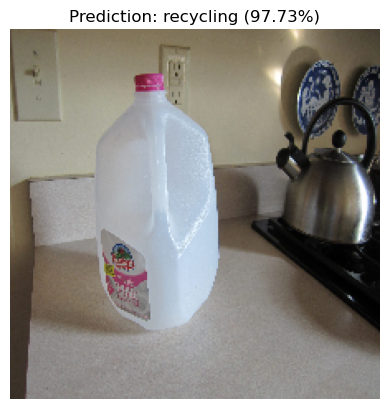

In [11]:
# Load trained model (CNN)
model = load_model("best_model.h5")

# Load and preprocess the image
img_path = "C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Machine Learning/Project/Project/Project Code & Data/Data/test_new_images/empty_milk_jug.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict the class of the uploaded image using the trained CNN model
predictions = model.predict(img_array)
class_index = np.argmax(predictions)

# Map index to label
class_labels = ['compost', 'general', 'recycling']
predicted_label = class_labels[class_index]
confidence = predictions[0][class_index] * 100

# Show result
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)")
plt.show()

This image shows the output of the smart waste classifier when presented with an empty milk jug. The trained CNN model confidently predicts the waste category as recycling with a 97.73% confidence score. This demonstrates that the model effectively recognizes recyclable plastic materials supporting its practical use in automated waste sorting applications such as recycling kiosks, smart bins or mobile waste classification apps.